### things to do
- rewrite descriptor generation code
- do PCA on the descriptor
- try SVM first, GRR



In [1]:
## import data
import numpy as np
import pandas as pd
%matplotlib inline
data =  pd.read_csv('new_stability_output_with_descriptors.csv', index_col=0) 
cdata = pd.read_csv('continuous_stability_output_with_descriptors.csv',index_col=0)
ddata = pd.read_csv('disc_stability_output_with_descriptors.csv',index_col=0)
X = data[data.columns[0:-1]]
Xc = cdata[cdata.columns[0:-1]]
Xd = ddata[ddata.columns[0:-1]]
y = cdata[cdata.columns[-1]]
mdata = pd.read_csv('continuous_stability_output_with_descriptors.csv',index_col=0)
yl = mdata[mdata.columns[-1]]
# label the instance
# Energy above 40 meV is considered to be unstable
y[y<=40] = 1
y[y>40] = 0

In [6]:
mydata = pd.read_csv('DS_featureSelected_Scaled_v1.1.csv',index_col=0) 

plot the data distribution

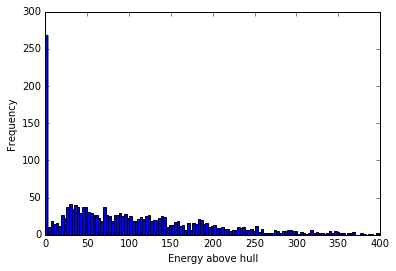

In [3]:
import matplotlib.pyplot as plt
yhist = y.plot.hist(bins=1000)
plt.xlim(0,400)
plt.xlabel('Energy above hull')

data pre-processing 
(kind of cheating here, needs to be revisited later)

In [2]:
from sklearn import preprocessing
## scale the features
Xc_scaled = preprocessing.scale(Xc)
Xd_scaled = preprocessing.scale(Xd)
## remove constant feature
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold()
Xc_ns = sel.fit_transform(Xc_scaled)
Xd_ns = sel.fit_transform(Xd_scaled)
## do PCA learning, keep 0.99 variance
## select K-best, keep top 10 score features
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline, FeatureUnion
import pylab as pl
pca = PCA(n_components=0.99)
selection = SelectKBest(k=3)
combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)])
Xc_con = combined_features.fit_transform(Xc_ns, y)
Xd_con = combined_features.fit_transform(Xd_ns, y)
X_features = np.concatenate((Xc_con,Xd_con),axis=1)

In [3]:
X_features.shape

(1956, 112)

write into files

In [5]:
## write into files
header = np.array(range(-2, X_features[1].size+1),dtype=str)
header[0] = ''
header[1] = 'stability'
header[2] = 'Energy above hull'
header = header.reshape(1,-1)
cdata = pd.read_csv('continuous_stability_output_with_descriptors.csv',index_col=0)
yn = cdata[cdata.columns[-1]]
yn = yn.reshape(-1,1)
mdata = pd.read_csv('continuous_stability_output_with_descriptors.csv',index_col=0)
yl = mdata[mdata.columns[-1]]
yl[yl<=40] = 1
yl[yl>40] = 0
yl = yl.reshape(-1,1)
index = np.arange(1,X_features.shape[0]+1).reshape(-1,1)
descriptors = np.concatenate((index,yl,yn,X_features),axis = 1)
datasetwithheader = np.concatenate((header,descriptors),axis = 0)
np.savetxt("DS_featureSelected_Scaled_v1.1.csv", datasetwithheader,  fmt="%s", delimiter=',')

In [4]:
X_total = np.concatenate((Xc,Xd),axis=1)
## write into files
header = np.array(range(-2, X_total[1].size+1),dtype=str)
header[0] = ''
header[1] = 'stability'
header[2] = 'Energy above hull'
header = header.reshape(1,-1)
y = y.reshape(-1,1)
yl = yl.reshape(-1,1)
index = np.arange(1,X_total.shape[0]+1).reshape(-1,1)
descriptors = np.concatenate((index,y,yl,X_total),axis = 1)
datasetwithheader = np.concatenate((header,descriptors),axis = 0)
np.savetxt("DS_allfeatures_v1.0.csv", datasetwithheader,  fmt="%s", delimiter=',')

# current probelm
## 1.tune parameters
## 2.try better model
## 3.set up the cv process
## 4.reduce the dimension

# tune the parameter with these desccriptors
#### work on random forest and neural network parameter tunning




In [4]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit

sdg = SGDClassifier(loss='hinge', penalty='l1', alpha=1e-3, n_iter=5, random_state=0)
mycv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
scores = cross_val_score(sdg, X_features, y, cv = mycv)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.83 (+/- 0.04)


In [5]:
from sklearn.ensemble import RandomForestClassifier
crand = RandomForestClassifier(n_estimators=100)
mycv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
scores = cross_val_score(crand, X_features, y, cv = mycv)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.91 (+/- 0.03)


In [86]:
from sklearn.ensemble import RandomForestClassifier
crand = RandomForestClassifier(n_estimators=100, min_samples_split = 5, n_jobs = 4)
mycv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
scores = cross_val_score(crand, X_features, y, cv = mycv)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.91 (+/- 0.03)


In [73]:
from sklearn.neural_network import MLPClassifier
cmlp = MLPClassifier(activation='relu', solver='adam', alpha=1e-1, hidden_layer_sizes=(35,8), max_iter=700)
mycv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
scores = cross_val_score(cmlp, X_features, y, cv = mycv)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.91 (+/- 0.03)


In [42]:
from sklearn.neural_network import MLPClassifier
cmlp = MLPClassifier(activation='relu', solver='adam', alpha=1e-1, hidden_layer_sizes=(35,8), max_iter=700)
mycv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
scores = cross_val_score(cmlp, X_features, y, cv = mycv)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

array([ 0.90816327,  0.91581633,  0.93112245,  0.88010204,  0.91581633])

Data transformation with held out data
Just as it is important to test a predictor on data held-out from training, preprocessing (such as standardization, feature selection, etc.) and similar data transformations similarly should be learnt from a training set and applied to held-out data for prediction:

In [61]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_features, y, test_size=0.2, random_state=0)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_transformed = scaler.transform(X_train)
cmlp.fit(X_train_transformed, y_train)
X_test_transformed = scaler.transform(X_test)
cmlp.score(X_test_transformed, y_test) 

0.92346938775510201

In [69]:
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y, test_size=0.2, random_state=300, stratify = y)
print(len(y_train[y_train==1])/len(y_train[y_train==0]))
print(len(y_test[y_test==1])/len(y_test[y_test==0]))
cmlp.fit(X_train,y_train)
y_true, y_pred = y_train, cmlp.predict(X_train)
print(confusion_matrix(y_true, y_pred))
y_true, y_pred = y_test, cmlp.predict(X_test)
print(confusion_matrix(y_true, y_pred))
print(accuracy_score(y_true, y_pred))

0.4141048824593128
0.4151624548736462
[[1103    3]
 [   3  455]]
[[266  11]
 [ 22  93]]
0.915816326531


A Pipeline makes it easier to compose estimators, providing this behavior under cross-validation:

## TODO
look into preprocessing.StandardScaler(), pipeline

In [28]:
from sklearn.pipeline import make_pipeline
clf = make_pipeline(preprocessing.StandardScaler(), cmlp)
cross_val_score(cmlp, X_features, y, cv=mycv)

array([ 0.90816327,  0.90561224,  0.91581633,  0.88010204,  0.91326531])

* make a parameter search 
* look into MLP, RandFor
* **implement the forward selection**
* confusion matrix

In [15]:
from time import time
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# build a classifier
clf = RandomForestClassifier(n_estimators=20)


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(1, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "n_estimators": sp_randint(20, 100),
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 200
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search,cv = mycv)

start = time()
random_search.fit(X_features, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

# use a full grid over all parameters
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [1, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "n_estimators": [20,50,100],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid,cv = mycv)
start = time()
grid_search.fit(X_features, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

RandomizedSearchCV took 644.79 seconds for 200 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.904 (std: 0.020)
Parameters: {'n_estimators': 83, 'criterion': 'entropy', 'min_samples_split': 8, 'bootstrap': False, 'max_features': 8, 'min_samples_leaf': 2, 'max_depth': None}

Model with rank: 2
Mean validation score: 0.903 (std: 0.021)
Parameters: {'n_estimators': 44, 'criterion': 'gini', 'min_samples_split': 6, 'bootstrap': False, 'max_features': 10, 'min_samples_leaf': 3, 'max_depth': None}

Model with rank: 3
Mean validation score: 0.902 (std: 0.020)
Parameters: {'n_estimators': 69, 'criterion': 'gini', 'min_samples_split': 6, 'bootstrap': False, 'max_features': 9, 'min_samples_leaf': 2, 'max_depth': None}

GridSearchCV took 3088.31 seconds for 648 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.908 (std: 0.019)
Parameters: {'n_estimators': 20, 'criterion': 'entropy', 'min_samples_split': 1, 'bootstrap': False, 'max_features': 10, '

In [43]:
?MLPClassifier

Object `MLPClassifier` not found.


In [57]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(
    X_features, y, test_size=0.2, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = {'activation': ['logistic', 'tanh','relu'],
                    'hidden_layer_sizes' : [(45,5),(35,10),(55,10),(35,8)]}

scores = ['precision', 'accuracy']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(MLPClassifier(max_iter = 700,alpha = 0.1), tuned_parameters, cv=mycv,
                       scoring=score, n_jobs = 4)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Note the problem is too easy: the hyperparameter plateau is too flat and the
# output model is the same for precision and recall with ties in quality.

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'activation': 'logistic', 'hidden_layer_sizes': (35, 10)}

Grid scores on development set:

0.831 (+/-0.056) for {'activation': 'logistic', 'hidden_layer_sizes': (45, 5)}
0.857 (+/-0.070) for {'activation': 'logistic', 'hidden_layer_sizes': (35, 10)}
0.847 (+/-0.038) for {'activation': 'logistic', 'hidden_layer_sizes': (55, 10)}
0.845 (+/-0.091) for {'activation': 'logistic', 'hidden_layer_sizes': (35, 8)}
0.817 (+/-0.034) for {'activation': 'tanh', 'hidden_layer_sizes': (45, 5)}
0.827 (+/-0.066) for {'activation': 'tanh', 'hidden_layer_sizes': (35, 10)}
0.854 (+/-0.082) for {'activation': 'tanh', 'hidden_layer_sizes': (55, 10)}
0.839 (+/-0.037) for {'activation': 'tanh', 'hidden_layer_sizes': (35, 8)}
0.840 (+/-0.084) for {'activation': 'relu', 'hidden_layer_sizes': (45, 5)}
0.845 (+/-0.070) for {'activation': 'relu', 'hidden_layer_sizes': (35, 10)}
0.843 (+/-0.061) for {'activation': 'relu', 'hid

In [75]:
?RandomForestClassifier

In [89]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(
    X_features, y, test_size=0.2, random_state=0, stratify = y)

# Set the parameters by cross-validation
tuned_parameters = {'n_estimators': [10,30,50, 70,100,150],
                    'class_weight' : ['balanced', None]}

scores = ['precision', 'accuracy']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(RandomForestClassifier(n_jobs=4), tuned_parameters, cv=mycv,
                       scoring=score, n_jobs = 4)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'n_estimators': 70, 'class_weight': 'balanced'}

Grid scores on development set:

0.855 (+/-0.105) for {'n_estimators': 10, 'class_weight': 'balanced'}
0.872 (+/-0.099) for {'n_estimators': 30, 'class_weight': 'balanced'}
0.880 (+/-0.094) for {'n_estimators': 50, 'class_weight': 'balanced'}
0.882 (+/-0.093) for {'n_estimators': 70, 'class_weight': 'balanced'}
0.872 (+/-0.097) for {'n_estimators': 100, 'class_weight': 'balanced'}
0.872 (+/-0.100) for {'n_estimators': 150, 'class_weight': 'balanced'}
0.847 (+/-0.105) for {'n_estimators': 10, 'class_weight': None}
0.865 (+/-0.093) for {'n_estimators': 30, 'class_weight': None}
0.855 (+/-0.083) for {'n_estimators': 50, 'class_weight': None}
0.859 (+/-0.096) for {'n_estimators': 70, 'class_weight': None}
0.866 (+/-0.092) for {'n_estimators': 100, 'class_weight': None}
0.869 (+/-0.093) for {'n_estimators': 150, 'class_weight': None}

Detailed classificat

In [94]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
clf = RandomForestClassifier(n_estimators=70,class_weight='balanced',n_jobs=4)
clf.fit(X_train,y_train)
y_true, y_pred = y_train, clf.predict(X_train)
print(confusion_matrix(y_true, y_pred))
y_true, y_pred = y_test, clf.predict(X_test)
print(confusion_matrix(y_true, y_pred))

[[1106    0]
 [   0  458]]
[[261  16]
 [ 21  94]]


In [114]:
clf = RandomForestClassifier(n_estimators=70,class_weight='balanced',n_jobs=4)
clf.fit(X_features,y)
y_true, y_pred = y_train, clf.predict(X_train)
print(confusion_matrix(y_true, y_pred))
y_true, y_pred = y_test, clf.predict(X_test)
print(confusion_matrix(y_true, y_pred))

[[1105    1]
 [   0  458]]
[[276   1]
 [  0 115]]


In [153]:
## ROC CUrve
from sklearn.metrics import roc_curve,auc
clf = RandomForestClassifier(n_estimators=70,class_weight='balanced',n_jobs=4)
y_score = clf.fit(X_train, y_train).predict_proba(X_test)


In [156]:
roc_auc[1] = auc(fpr[1], tpr[1])

In [169]:
auc(fpr[1], tpr[1])

0.95151467587505889

In [167]:
tpr[1]

array([ 0.0173913 ,  0.03478261,  0.05217391,  0.07826087,  0.08695652,
        0.12173913,  0.15652174,  0.1826087 ,  0.25217391,  0.29565217,
        0.35652174,  0.36521739,  0.4173913 ,  0.44347826,  0.46086957,
        0.50434783,  0.52173913,  0.53913043,  0.5826087 ,  0.6       ,
        0.6       ,  0.60869565,  0.6173913 ,  0.64347826,  0.68695652,
        0.70434783,  0.71304348,  0.73043478,  0.73913043,  0.75652174,
        0.76521739,  0.79130435,  0.8       ,  0.82608696,  0.85217391,
        0.87826087,  0.88695652,  0.88695652,  0.89565217,  0.90434783,
        0.90434783,  0.90434783,  0.90434783,  0.90434783,  0.91304348,
        0.93913043,  0.93913043,  0.93913043,  0.93913043,  0.94782609,
        0.94782609,  0.94782609,  0.96521739,  0.97391304,  0.9826087 ,
        0.9826087 ,  0.99130435,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ])

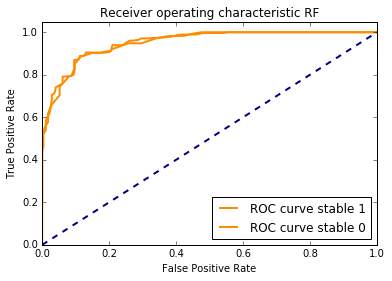

In [168]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    ytrue = np.array(y_test==i,dtype=int).reshape(-1,1)
    fpr[i], tpr[i], _ = roc_curve(ytrue, y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve stable 1' )
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve stable 0' )
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic RF')
plt.legend(loc="best")
plt.show()

In [125]:
## validation Curve
from sklearn.model_selection import validation_curve
from sklearn.utils import shuffle
X_shuffled, y_shuffled = shuffle(X_features, y, random_state=0)
my_param_range=[20,30,50,70,90,120,150,200,300]
train_scores, valid_scores = validation_curve(clf, X_shuffled, y_shuffled, 
                                              param_name="n_estimators", 
                                              param_range=my_param_range, cv= mycv, scoring="precision",
                                              n_jobs = 4)


In [122]:
len(y_shuffled[y_shuffled==0])

1383

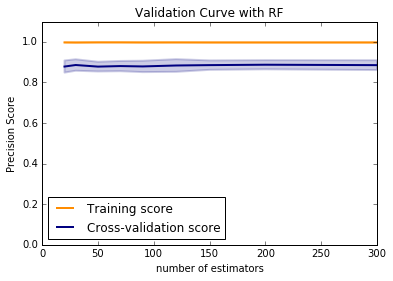

In [126]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)

import matplotlib.pyplot as plt

plt.title("Validation Curve with RF")
plt.xlabel("number of estimators")
plt.ylabel("Precision Score")
plt.ylim(0.0, 1.1)
lw = 2
param_range=my_param_range
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

<module 'matplotlib.pyplot' from '/Users/liwei/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py'>

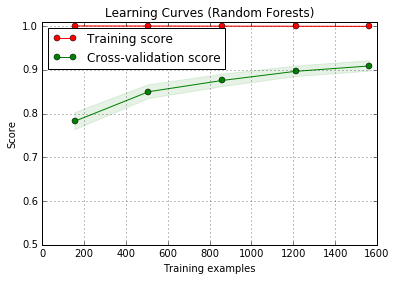

In [127]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

title = "Learning Curves (Random Forests)"
plot_learning_curve(clf, title, X_shuffled, y_shuffled, ylim=(0.5, 1.01), cv=mycv, n_jobs=4)

Optimal number of features : 93


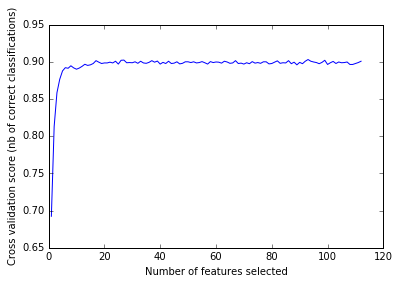

In [45]:
import pylab as pl
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
clf = RandomForestClassifier(n_estimators=100)
## clf = SGDClassifier(loss='hinge', penalty='l1', alpha=1e-3, n_iter=5, random_state=34)
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=clf, step=1, cv=mycv,
              scoring='accuracy')
rfecv.fit(X_features, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
pl.xlabel("Number of features selected")
pl.ylabel("Cross validation score (nb of correct classifications)")
pl.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
pl.show()

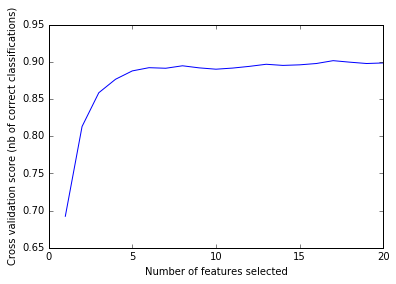

In [46]:
pl.xlabel("Number of features selected")
pl.ylabel("Cross validation score (nb of correct classifications)")
pl.plot(range(1, 20 + 1), rfecv.grid_scores_[0:20])
pl.show()

In [8]:
X.shape

(1956, 864)

Optimal number of features : 864


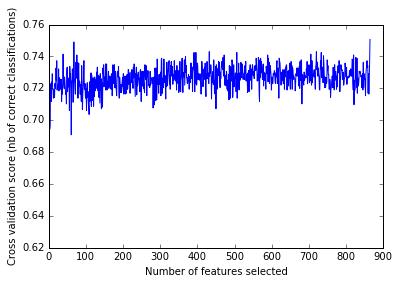

In [9]:
import pylab as pl
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
clf = RandomForestClassifier(n_estimators=50)
## clf = SGDClassifier(loss='hinge', penalty='l1', alpha=1e-3, n_iter=5, random_state=34)
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(5),
              scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
pl.xlabel("Number of features selected")
pl.ylabel("Cross validation score (nb of correct classifications)")
pl.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
pl.show()

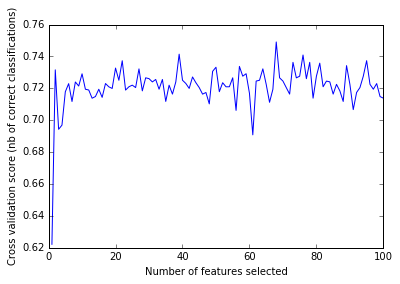

In [11]:
# Plot number of features VS. cross-validation scores
pl.xlabel("Number of features selected")
pl.ylabel("Cross validation score (nb of correct classifications)")
pl.plot(range(1, 100 + 1), rfecv.grid_scores_[0:100])
pl.show()

In [41]:
# Authors: Robert McGibbon, Joel Nothman

import numpy as np
import pylab as pl

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier


pipe = Pipeline([
    ('reduce_dim', PCA()),
    ('classify', RandomForestClassifier())
])
## MLPClassifier(activation='logistic', solver='adam', alpha=1e-5, hidden_layer_sizes=(40, 20, 10, 5))
N_FEATURES_OPTIONS = [1, 3,  5, 9, 15, 21, 30]
N_ESTIMATORS = [50,  100, 150]
param_grid = [
    {
        'reduce_dim': [PCA()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classify__n_estimators': N_ESTIMATORS
    },
    {
        'reduce_dim': [SelectKBest()],
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'classify__n_estimators': N_ESTIMATORS
    },
]
reducer_labels = ['PCA', 'KBest()']

grid = GridSearchCV(pipe, cv=mycv, n_jobs=2, param_grid=param_grid)

grid.fit(X_features, y)

mean_scores = np.array(grid.cv_results_['mean_test_score'])
# scores are in the order of param_grid iteration, which is alphabetical
mean_scores = mean_scores.reshape(len(N_ESTIMATORS), -1, len(N_FEATURES_OPTIONS))
# select score for best C
mean_scores = mean_scores.max(axis=0)
bar_offsets = (np.arange(len(N_FEATURES_OPTIONS)) *
               (len(reducer_labels) + 1) + .5)

In [42]:
mean_scores = np.array(grid.cv_results_['mean_test_score'])
# scores are in the order of param_grid iteration, which is alphabetical
mean_scores = mean_scores.reshape(len(N_ESTIMATORS), -1, len(N_FEATURES_OPTIONS))
# select score for best C
mean_scores = mean_scores.max(axis=0)
bar_offsets = (np.arange(len(N_FEATURES_OPTIONS)) *
               (len(reducer_labels) + 1) + .5)

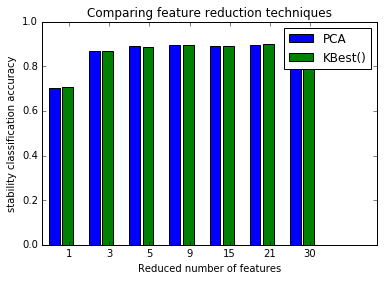

In [44]:
COLORS = 'bgrcmyk'
reducer_labels = ['PCA', 'KBest()', 'another()']
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    pl.bar(bar_offsets + i, reducer_scores, label=label, color=COLORS[i])

pl.title("Comparing feature reduction techniques")
pl.xlabel('Reduced number of features')
pl.xticks(bar_offsets + len(reducer_labels) / 2, N_FEATURES_OPTIONS)
pl.ylabel('stability classification accuracy')
pl.ylim((0, 1))
pl.legend(loc='upper right')

In [207]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.svm import SVR

X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=1)

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5)
StratifiedKFold(n_splits=2, random_state=None, shuffle=False)
for train_index, test_index in skf.split(X_features, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_features[train_index], X_features[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [ 301  302  303 ..., 1953 1954 1955] TEST: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 

In [95]:
X_train

array([[ 16.62083945,   6.74159888,   4.17025959, ...,  -0.05547002,
         -0.05547002,  -0.05547002],
       [  1.70356973,  -6.13999952,   3.90535532, ...,  -0.05547002,
         -0.05547002,  -0.05547002],
       [ -8.49265395,  -6.91084788,  -2.28482821, ...,  -0.05547002,
         -0.05547002,  -0.05547002],
       ..., 
       [ -6.95784602,   9.53452291,  -3.87328363, ...,  -0.05547002,
         -0.05547002,  -0.05547002],
       [ -1.61959596,  -7.43360657,   1.63103641, ...,  -0.05547002,
         -0.05547002,  -0.05547002],
       [ -7.5789749 ,  -5.35710109,  -1.39782635, ...,  -0.05547002,
         -0.05547002,  -0.05547002]])

In [23]:
from sklearn.svm import SVC
pca = PCA(n_components=5)
X_1 = pca.fit_transform(X_features, y)
clf = SVC()
scores = cross_val_score(clf, X_1, y, cv = 5)
scores.mean()

0.70654631083202513

In [133]:
clf

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [118]:
from sklearn.svm import LinearSVC
clf = LinearSVC(C=100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [96]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(activation='logistic', solver='lbfgs', alpha=1e-3, hidden_layer_sizes=(20,7))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [34]:
?MLPClassifier

In [194]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=150)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
scores = cross_val_score(clf, X_features, y, cv = 5)
scores.mean()

0.75064364207221357

In [33]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=150)
clf.fit(X_train, y_train)
scores = cross_val_score(clf, X_features, y, cv = 5)
scores.mean()

0.71886708529565679

In [59]:
from sklearn.linear_model import SGDClassifier
sdg = SGDClassifier(loss='hinge', penalty='l1', alpha=1e-3, n_iter=5, random_state=34)
sdg.fit(X_train, y_train)
y_pred = sdg.predict(X_test)
scores = cross_val_score(sdg, X_features, y, cv = 5)
scores.mean()

0.67245159602302462

In [192]:
sum(y_train)/y_train.size

0.70332480818414322

In [204]:
clf.score(X=X_test,y=y_test)

0.89030612244897955

In [202]:
from sklearn.model_selection import cross_val_score
clf = MLPClassifier(activation='logistic', solver='lbfgs', alpha=1e-3, hidden_layer_sizes=(20, 7))
## clf = RandomForestClassifier(n_estimators=150)
## clf = LinearSVC(C=100)
clf.fit(X_train, y_train)
scores = cross_val_score(clf, X_features, y, scoring='accuracy', cv = 5)
scores.mean()


0.72292778649921507

In [198]:
?cross_val_score

In [43]:
from sklearn import metrics
print(metrics.classification_report(y_train, y_train))
metrics.confusion_matrix(y_train, y_train)

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00       432
        1.0       1.00      1.00      1.00      1035

avg / total       1.00      1.00      1.00      1467



array([[ 432,    0],
       [   0, 1035]])

# Regression

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_features, yl, test_size=0.2, random_state=0, stratify = y)

In [16]:
len(y_train[y_train<=40])/len(y_train)

0.2928388746803069

In [17]:
len(y_test[y_test<=40])/len(y_test)

0.29336734693877553

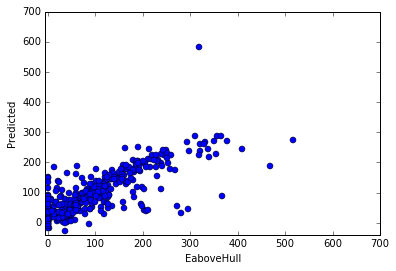

In [18]:
from sklearn.svm import SVR

##svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_lin = SVR(kernel='linear')
##svr_poly = SVR(kernel='poly', C=1e3, degree=2)
##y_rbf = svr_rbf.fit(X_train, y_train).predict(X_test)
svr_lin.fit(X_train, y_train)
##y_poly = svr_poly.fit(X, y).predict(X)


##pl.hold('on')
#pl.plot (y_test, y_pred, "bo", label='RBF model')
#pl.plot (y_test, y_lin, "ro", label='lin model')
#pl.plot (y_test, y_pred, "ko", label='poly model')

y_plin = svr_lin.predict(X_test)
pl.plot (y_test, y_plin, "bo", label='lin model')
pl.ylim((-40,700))
pl.xlim((-5, 700))
pl.xlabel("EaboveHull")
pl.ylabel("Predicted")

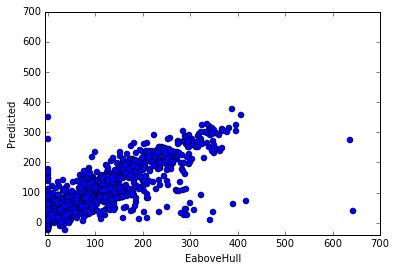

In [19]:
y_plin = svr_lin.predict(X_train)
pl.plot (y_train, y_plin, "bo", label='lin model')
pl.ylim((-40,700))
pl.xlim((-5, 700))
pl.xlabel("EaboveHull")
pl.ylabel("Predicted")

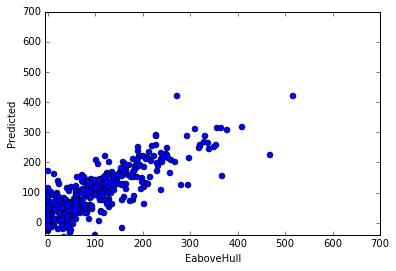

In [28]:
### try lesso
from sklearn import linear_model
clf = linear_model.Lasso(alpha = 0.003, max_iter=70000)
clf.fit(X_train, y_train)
y_plin = clf.predict(X_test)
pl.plot (y_test, y_plin, "bo", label='lin model')
pl.ylim((-40,700))
pl.xlim((-5, 700))
pl.xlabel("EaboveHull")
pl.ylabel("Predicted")


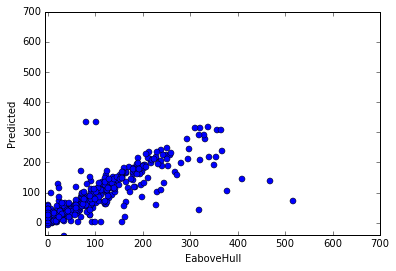

In [37]:
from sklearn.kernel_ridge import KernelRidge
clf = KernelRidge(alpha = 0.3, kernel="rbf")
clf.fit(X_train, y_train)
y_plin = clf.predict(X_test)
pl.plot (y_test, y_plin, "bo", label='lin model')
pl.ylim((-40,700))
pl.xlim((-5, 700))
pl.xlabel("EaboveHull")
pl.ylabel("Predicted")

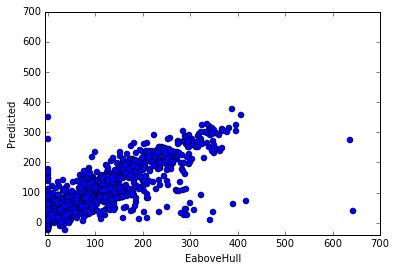

In [38]:
y_plin = svr_lin.predict(X_train)
pl.plot (y_train, y_plin, "bo", label='lin model')
pl.ylim((-40,700))
pl.xlim((-5, 700))
pl.xlabel("EaboveHull")
pl.ylabel("Predicted")

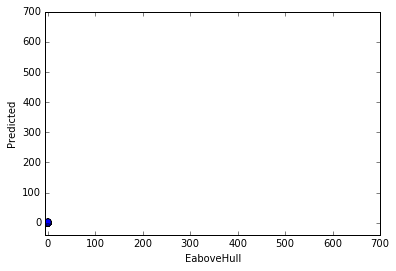

In [10]:
y_plin = svr_lin.predict(X_test)
pl.plot (y_test, y_plin, "bo", label='lin model')
pl.ylim((-40,700))
pl.xlim((-5, 700))
pl.xlabel("EaboveHull")
pl.ylabel("Predicted")

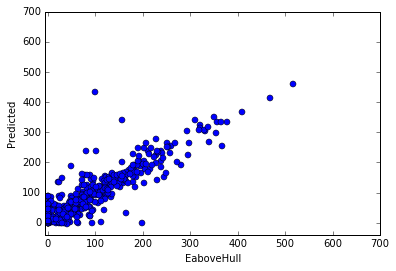

In [42]:
from sklearn.neural_network import MLPRegressor

clf = MLPRegressor(activation='relu', solver='adam', alpha=1e-1, hidden_layer_sizes=(20,8), max_iter=700)
clf.fit(X_train, y_train)
y_plin = clf.predict(X_test)
pl.plot (y_test, y_plin, "bo", label='lin model')
pl.ylim((-40,700))
pl.xlim((-5, 700))
pl.xlabel("EaboveHull")
pl.ylabel("Predicted")

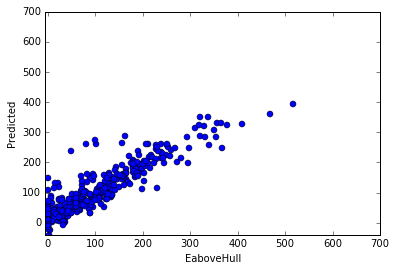

In [44]:
from sklearn.neural_network import MLPRegressor

clf = MLPRegressor(activation='relu', solver='adam', alpha=1e-1, hidden_layer_sizes=(35,8), max_iter=700)
clf.fit(X_train, y_train)
y_plin = clf.predict(X_test)
pl.plot (y_test, y_plin, "bo", label='lin model')
pl.ylim((-40,700))
pl.xlim((-5, 700))
pl.xlabel("EaboveHull")
pl.ylabel("Predicted")

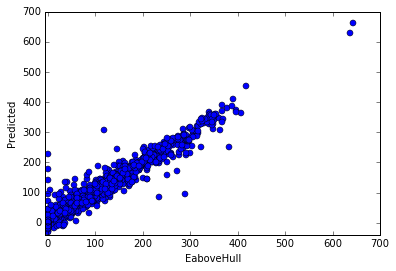

In [41]:
y_plin = clf.predict(X_train)
pl.plot (y_train, y_plin, "bo", label='lin model')
pl.ylim((-40,700))
pl.xlim((-5, 700))
pl.xlabel("EaboveHull")
pl.ylabel("Predicted")

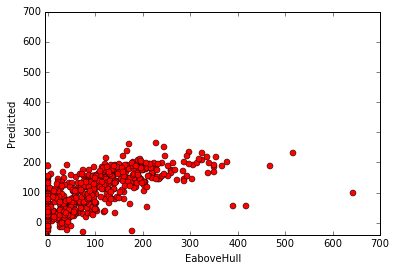

In [66]:
pl.plot (y_test, y_lin, "ro", label='lin model')
pl.ylim((-40,700))
pl.xlim((-5, 700))
pl.xlabel("EaboveHull")
pl.ylabel("Predicted")

In [57]:
X_features.shape

(2040, 26)

In [36]:
pca.components_

array([[ -9.73164727e-17,   5.10702591e-15,  -7.85830214e-17, ...,
         -3.40753471e-14,  -6.71324131e-14,  -6.74778552e-17],
       [ -1.32986006e-05,   1.51976925e-04,  -2.97422299e-05, ...,
         -4.08857667e-03,  -7.14394354e-03,  -2.17703929e-06],
       [  6.20529886e-06,   1.15431117e-03,   2.05187209e-05, ...,
          4.29259940e-03,   6.79651960e-03,  -7.94320204e-06]])

In [37]:
print(__doc__)

import pylab as plt

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

iris = datasets.load_iris()

X = iris.data
y = iris.target
target_names = iris.target_names

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))


Automatically created module for IPython interactive environment
explained variance ratio (first two components): [ 0.92461621  0.05301557]


In [45]:
np.dot(pca.components_[0],X[0])

2.8271359726790251

In [25]:
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.svm import SVR
import pylab as pl

X_train, X_test, y_train, y_test = train_test_split(X_features, y, random_state=1)

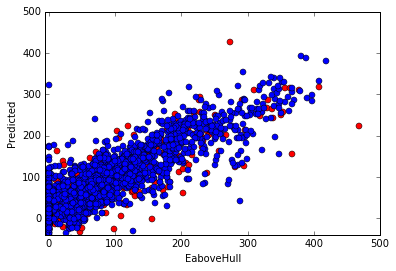

In [39]:


# import model
from sklearn.linear_model import LinearRegression

# instantiate
linreg = LinearRegression()

# fit the model to the training data (learn the coefficients)
linreg.fit(X_train, y_train)

y_lin = linreg.predict(X_test)

pl.hold('on')
pl.plot (y_test, y_lin, "ro", label='lin model')
#pl.plot (y_test, y_pred, "ko", label='poly model')
pl.plot (y_train, linreg.predict(X_train), "bo", label='train model')

pl.ylim((-40,500))
pl.xlim((-5, 500))
pl.xlabel("EaboveHull")
pl.ylabel("Predicted")



In [ ]:
svr_poly = SVR(kernel='poly', C=1e3, degree=2)
y_mlin = svr_poly.fit(X_train, y_train)
y_plin = svr_lin.predict(X_test)
pl.plot (y_test, y_plin, "bo", label='poly model')
pl.ylim((-40,700))
pl.xlim((-5, 700))
pl.xlabel("EaboveHull")
pl.ylabel("Predicted")

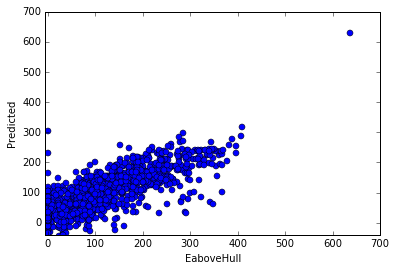

In [32]:
y_plin = svr_lin.predict(X_train)
pl.plot (y_train, y_plin, "bo", label='lin model')
pl.ylim((-40,700))
pl.xlim((-5, 700))
pl.xlabel("EaboveHull")
pl.ylabel("Predicted")

In [ ]:
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.svm import SVR
import pylab as pl

X_train, X_test, y_train, y_test = train_test_split(X_features, y, random_state=1)

##svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_lin = SVR(kernel='linear', C=1e3)
##svr_poly = SVR(kernel='poly', C=1e3, degree=2)
##y_rbf = svr_rbf.fit(X_train, y_train).predict(X_test)
y_lin = svr_lin.fit(X_train, y_train).predict(X_test)
##y_poly = svr_poly.fit(X, y).predict(X)


##pl.hold('on')
#pl.plot (y_test, y_pred, "bo", label='RBF model')
pl.plot (y_test, y_lin, "ro", label='lin model')
#pl.plot (y_test, y_pred, "ko", label='poly model')

pl.ylim((-40,1000))
pl.xlim((-5, 1000))
pl.xlabel("EaboveHull")
pl.ylabel("Predicted")

#pl.legend()


In [133]:
pca.explained_variance_ratio_

array([  1.00000000e+00,   1.24201536e-20,   6.90454880e-21])

In [135]:
selection = SelectKBest(k=10)
combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)])
X_features = combined_features.fit(X, y).transform(X)

/Users/liwei/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [  1   2   3   4  21  24  62  89 100 103 106 108 109 110 117 118 123 125
 143 146 183 223 226 263 304 307 345 386 389 427 468 471 509 549 552 586
 589 592 626 629 632] are constant.
  UserWarning)


In [147]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_features, y, random_state=1)

In [148]:
svm.fit(X_train, y_train)

print(linreg.intercept_)
print(linreg.coef_)
y_pred = linreg.predict(X_test)
import pylab as pl
pl.plot (y_test, y_pred, "bo")
pl.ylim((-40,1000))
pl.xlim((-5, 1000))
pl.xlabel("EaboveHull")
pl.ylabel("Predicted")

ValueError: Unknown label type: 465.0       0.000000
1955.0    123.035360
508.0      33.436112
1420.0      0.000000
1729.0    141.535230
1442.0     45.937188
1549.0      0.000000
234.0     110.674570
1579.0    113.718260
1082.0    112.287386
2008.0    178.519868
1959.0    139.928045
1978.0     53.128245
556.0     131.304680
586.0       0.000000
463.0       0.000000
951.0      66.761333
645.0      39.831207
1370.0     55.088616
808.0      52.168670
284.0      75.878245
447.0       0.000000
805.0       0.000000
1612.0    142.333954
65.0       71.546616
59.0      202.290968
256.0     198.061859
1552.0    100.949225
1768.0    262.896301
1490.0     25.115635
             ...    
399.0      33.138455
1950.0    109.381016
669.0      35.158395
1515.0      0.000000
253.0     274.349274
908.0      91.344997
469.0       0.000000
915.0     141.373726
358.0      74.772053
1279.0     28.663759
1301.0      0.000000
1203.0     97.255696
1306.0     29.915707
1415.0    110.664774
509.0       7.745588
750.0     100.440195
1608.0     83.917196
1997.0    238.535058
130.0      54.949790
145.0      77.045021
961.0       0.000000
848.0      51.309016
1670.0    113.869162
716.0      62.494050
906.0       0.000000
1792.0    201.321423
1097.0     91.266975
1933.0     68.400903
236.0      78.671230
1062.0    185.051275
Name: Eab, dtype: float64

In [114]:
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

iris = load_iris()

X, y = iris.data, iris.target

# This dataset is way too high-dimensional. Better do PCA:
pca = PCA(n_components=2)

# Maybe some original features where good, too?
selection = SelectKBest(k=1)

# Build estimator from PCA and Univariate selection:

combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)])

# Use combined features to transform dataset:
X_features = combined_features.fit(X, y).transform(X)

svm = SVC(kernel="linear")

svm.fit(X,y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [126]:
pca = PCA(n_components=0.99)

In [127]:
X_pca = pca.fit_transform(X)
pca.explained_variance_ratio_

array([ 0.92461621,  0.05301557,  0.01718514])

In [41]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [42]:
# default split is 75% for training and 25% for testing
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1530, 1222)
(1530,)
(510, 1222)
(510,)


28846.3437097
[ -9.03478269  54.20814933 -56.67390753 ..., -24.71284165  -3.18450351
  -7.57379285]


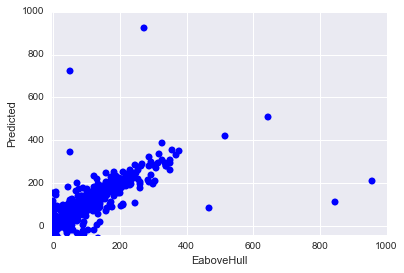

In [63]:
# import model
from sklearn.linear_model import LinearRegression

# instantiate
linreg = LinearRegression()

# fit the model to the training data (learn the coefficients)
linreg.fit(X_train, y_train)

print(linreg.intercept_)
print(linreg.coef_)
y_pred = linreg.predict(X_test)
import pylab as pl
pl.plot (y_test, y_pred, "bo")
pl.ylim((-40,1000))
pl.xlim((-5, 1000))
pl.xlabel("EaboveHull")
pl.ylabel("Predicted")

In [59]:
?linreg.score

In [62]:
np.sqrt(np.mean((y_test-y_pred)**2))

927.93894501440536

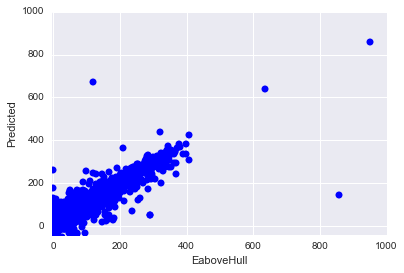

In [65]:
y_tot = linreg.predict(X_train)
import pylab as pl
pl.plot (y_train, y_tot, "bo")
pl.ylim((-40,1000))
pl.xlim((-5, 1000))
pl.xlabel("EaboveHull")
pl.ylabel("Predicted")

In [61]:
y_test-y_pred

1684.0     18.463849
1007.0    -21.210230
1009.0    -52.598981
1922.0      0.570853
895.0       0.024078
1898.0     59.714030
407.0       8.963895
528.0     -35.992932
373.0      32.447905
1397.0    -19.581360
1668.0     24.191394
390.0     100.602051
1710.0     81.971652
1824.0     -6.605609
772.0     -10.004016
1235.0     -7.241327
1981.0    -12.712780
824.0      13.166682
1737.0    -10.445607
919.0     600.754570
1323.0     11.891490
1900.0     88.550231
1506.0    -24.376222
57.0      -11.820463
397.0     -51.327252
644.0     103.661002
1473.0     22.951149
846.0      25.526795
841.0     -10.936130
1979.0    -40.884071
             ...    
1104.0    -39.176118
765.0      -7.858357
336.0      -0.793412
354.0      -2.302705
1791.0    -17.721435
1305.0      8.280254
614.0     -10.690478
40.0       29.436246
620.0      10.499226
1984.0    -69.389396
1625.0    -38.416224
967.0       8.101017
1012.0     -8.661006
81.0      -18.838751
435.0       9.615351
1142.0     34.404074
662.0      13

100.0
28846.3437097
[ -9.03478269  54.20814933 -56.67390753 ..., -24.71284165  -3.18450351
  -7.57379285]


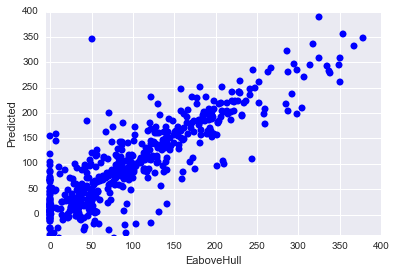

In [54]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha = 0.1)
clf.fit([[0, 0], [1, 1]], [0, 1])
clf = linear_model.RidgeCV(alphas=[0.1, 1.0, 10.0, 100])
clf.fit(X_train, y_train)
print(clf.alpha_)

print(linreg.intercept_)
print(linreg.coef_)
y_pred = linreg.predict(X_test)
import pylab as pl
pl.plot (y_test, y_pred, "bo")
pl.ylim((-40,400))
pl.xlim((-5, 400))
pl.xlabel("EaboveHull")
pl.ylabel("Predicted")

In [22]:
### try lesso
from sklearn import linear_model
clf = linear_model.Lasso(alpha = 0.003)
clf.fit(X_train, y_train)
y_predictbylesso = clf.predict(X_test)
pl.plot (y_test, y_predbylesso, "bo")
pl.ylim((-40,400))
pl.xlim((-5, 400))
pl.xlabel("EaboveHull")
pl.ylabel("Predicted")

/Users/liwei/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


NameError: name 'y_predbylesso' is not defined

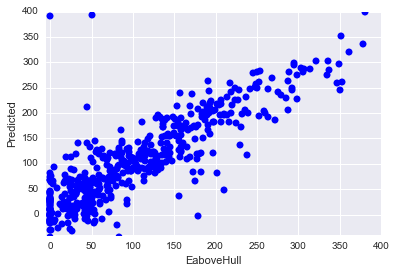

In [25]:
yP = clf.predict(X_test)
pl.plot (y_test, yP, "bo")
pl.ylim((-40,400))
pl.xlim((-5, 400))
pl.xlabel("EaboveHull")
pl.ylabel("Predicted")

In [39]:

from sklearn.feature_selection import SelectFromModel

clf = linear_model.Lasso(alpha = 300, tol=0.01)
lso = clf.fit(X_train, y_train)
model = SelectFromModel(lso, prefit=True)
X_new = model.transform(X_train)
X_new.shape

(1529, 23)

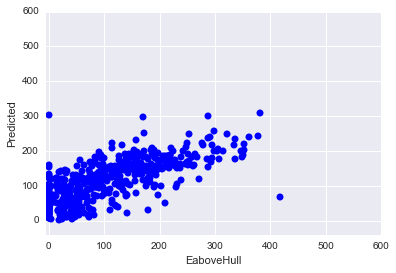

In [41]:
yP = clf.predict(X_test)
pl.plot (y_test, yP, "bo")
pl.ylim((-40,600))
pl.xlim((-5, 600))
pl.xlabel("EaboveHull")
pl.ylabel("Predicted")

In [7]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
X_pca = pca.fit_transform(X)

In [97]:
X_pca

array([[ -5.16119477e+11],
       [ -5.16119477e+11],
       [ -5.16119477e+11],
       ..., 
       [ -5.16119477e+11],
       [ -5.16119477e+11],
       [ -5.16119477e+11]])

In [88]:
pca.explained_variance_ratio_

array([  1.00000000e+00,   2.01233364e-20,   8.02967867e-21,
         6.59139119e-21,   4.34049822e-21,   1.52248847e-21,
         9.30281781e-22,   6.43115864e-22,   5.44033032e-22,
         3.74742182e-22,   2.65306426e-22,   2.11503110e-22])

In [95]:
from sklearn.cross_validation import train_test_split
X_train1, X_test1, y_train, y_test = train_test_split(X_pca, y, random_state=1)

106.637006258
[ -5.00304793e-13]


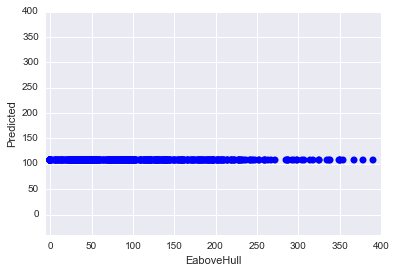

In [96]:
# import model
from sklearn.linear_model import LinearRegression

# instantiate
linreg = LinearRegression()

# fit the model to the training data (learn the coefficients)
linreg.fit(X_train1, y_train)

print(linreg.intercept_)
print(linreg.coef_)
y_pred = linreg.predict(X_test1)
import pylab as pl
pl.plot (y_test, y_pred, "bo")
pl.ylim((-40,400))
pl.xlim((-5, 400))
pl.xlabel("EaboveHull")
pl.ylabel("Predicted")